# library

In [596]:
from sqlalchemy import create_engine, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, scoped_session
from sqlalchemy.sql import text
import pandas as pd
from operator import attrgetter
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# global variables

In [101]:
dbname = 'test'
user = 'user_test'
password = 'Password123'
host = 'redshift-cluster-datawarehouse.cew9a5azwld4.us-east-1.redshift.amazonaws.com'
port = 5439
protocol = 'postgresql'

# Objects

In [185]:
class TrebleDBTest:
    def __init__(self, protocol, user, password, url, port, database):
        self.protocol = protocol
        self.user = user
        self.password = password
        self.url = url
        self.port = port
        self.database = database
        self.engine = None
        self.session = None

    def _build_connection_string(self):
        return f"{self.protocol}://{self.user}:{self.password}@{self.url}:{self.port}/{self.database}"

    def connect(self):
        connection_string = self._build_connection_string()
        self.engine = create_engine(connection_string)
        self.session = scoped_session(sessionmaker(bind=self.engine))
        print("Connection successful to Treble.AI datawarehouse!")

    def close(self):
        if self.session:
            self.session.remove()
        if self.engine:
            self.engine.dispose()

    def inspect_database(self):
        inspector = inspect(self.engine)

        # 1. Schemas
        print("Schemas:")
        schemas = inspector.get_schema_names()
        for schema in schemas:
            print(f"  - {schema}")
        print("\n")

        # 2. Tables, Columns, Indexes, Primary Keys, and Relations
        tables = inspector.get_table_names()
        for table in tables:
            print(f"Table: {table}")

            # Columns
            columns = inspector.get_columns(table)
            print("Columns:")
            for column in columns:
                print(f"  - {column['name']} ({column['type']})")

            # Indexes
            indexes = inspector.get_indexes(table)
            for index in indexes:
                print(f"  Index: {index['name']} (Columns: {', '.join(index['column_names'])})")

            # Foreign Keys
            fks = inspector.get_foreign_keys(table)
            if fks:
                print("Foreign Key Relations:")
                for fk in fks:
                    print(f"  - Constraint Name: {fk['name']}")
                    print(f"    Source: {fk['constrained_columns']}")
                    print(f"    References: {fk['referred_table']}({', '.join(fk['referred_columns'])})")

            # Unique Constraints
            unique_constraints = inspector.get_unique_constraints(table)
            for uc in unique_constraints:
                print(f"  Unique Constraint: {uc['name']} (Columns: {', '.join(uc['column_names'])})")

            # Check Constraints (may not be supported in Redshift)
            try:
                check_constraints = inspector.get_check_constraints(table)
                for cc in check_constraints:
                    print(f"  Check Constraint: {cc['name']} (Expression: {cc['expression']})")
            except NotImplementedError:
                pass

            print("\n")

        # 3. Views and View Definitions
        views = inspector.get_view_names()
        for view in views:
            print(f"View: {view}")
            view_definition = inspector.get_view_definition(view)
            print(f"Definition:\n{view_definition}")
            print("\n")

        # 4. Data Types (User Defined)
        print("User-Defined Types:")
        for schema in schemas:
            data_types = inspector.get_sorted_table_and_fkc_names(schema)
            for dtype in data_types:
                print(f"  - {dtype}")
        print("\n")

    def make_query(self, query):
        with self.engine.connect() as conn:
            query = conn.execute(text(query))
        reader = pd.DataFrame(query.fetchall())

        return reader


## Connection test

In [186]:
conn_params = {
    "protocol": protocol,
    "user": user,
    "password": password,
    "url": host,
    "port": port,
    "database": dbname
}
db_connection = TrebleDBTest(**conn_params)
try:
    db_connection.connect()
finally:
    db_connection.close()


Connection successful to Treble.AI datawarehouse!


# Exploring database structure

In [187]:
db_connection.connect()
db_connection.inspect_database()

Connection successful to Treble.AI datawarehouse!
Schemas:
  - catalog_history
  - information_schema
  - public


Table: company
Columns:
  - id (INTEGER)
  - name (VARCHAR(255))
  - associated_partner (VARCHAR(255))
  - close_date (TIMESTAMP)


Table: company_identifiers
Columns:
  - account_identifier (INTEGER)
  - company_id (INTEGER)
  - stripe_company_ids (VARCHAR(255))


Table: stripe_invoice
Columns:
  - sent_date (TIMESTAMP)
  - invoice_id (VARCHAR(255))
  - company_id (VARCHAR(255))
  - amount (INTEGER)
  - currency (VARCHAR(50))


Table: conversations
Columns:
  - account_id (INTEGER)
  - total (INTEGER)
  - date (DATE)
  - successful (BOOLEAN)
  - id (INTEGER)


User-Defined Types:
  - (None, [])
  - ('sql_features', set())
  - ('sql_implementation_info', set())
  - ('sql_languages', set())
  - ('sql_packages', set())
  - ('sql_sizing', set())
  - ('sql_sizing_profiles', set())
  - (None, [])
  - ('company', set())
  - ('company_identifiers', set())
  - ('stripe_invoice', s

## Tables

### - company

In [459]:
query_get_companies = """
select
    *
from company as c
;
"""
companies = db_connection.make_query(query=query_get_companies)
print(f'Number of columns: {companies.shape[1]} - Number of rows: {companies.shape[0]}')
print(f'Columns: {list(companies.columns)}')
companies

Number of columns: 4 - Number of rows: 14
Columns: ['id', 'name', 'associated_partner', 'close_date']


,id,name,associated_partner,close_date
0,1,Test Company,Test Partner,2023-01-02
1,2,Quantum Bright Industries,None,2023-02-04
2,3,Quantum Bright Industries,Partner SSL,2023-03-01
3,5,Innovative Bright Systems,,2023-02-23
4,6,Evolve Smart Systems,,2023-04-04
5,7,Tech United Enterprises,,2023-04-04
6,8,Evolve Creative Innovations,,2023-01-24
7,9,Evolve United Systems,,2023-01-11
8,10,Delta Reliable Innovations,,2023-02-01
9,11,Solutions Trusted Partners,,2023-04-11


### - company identifiers

In [158]:
query_get_company_identifiers = """
select
    *
from company_identifiers as c
;
"""
company_identifiers = db_connection.make_query(query=query_get_company_identifiers)
print(f'Number of columns: {company_identifiers.shape[1]} - Number of rows: {company_identifiers.shape[0]}')
print(f'Columns: {list(company_identifiers.columns)}')
company_identifiers

Number of columns: 3 - Number of rows: 21
Columns: ['account_identifier', 'company_id', 'stripe_company_ids']


,account_identifier,company_id,stripe_company_ids
0,1,1,"ak_1, ak_2"
1,2,1,"ak_1, ak_2"
2,3,2,ak_3
3,4,3,ak_4
4,5,3,ak_4
5,6,4,
6,7,5,ak_5
7,8,6,ak_7
8,9,7,ak_8
9,10,7,ak_8


### - stripe invoice

In [159]:
query_get_stripe_invoice = """
select
    *
from stripe_invoice as c
;
"""
stripe_invoice = db_connection.make_query(query=query_get_stripe_invoice)
print(f'Number of columns: {stripe_invoice.shape[1]} - Number of rows: {stripe_invoice.shape[0]}')
print(f'Columns: {list(stripe_invoice.columns)}')
stripe_invoice

Number of columns: 5 - Number of rows: 67
Columns: ['sent_date', 'invoice_id', 'company_id', 'amount', 'currency']


,sent_date,invoice_id,company_id,amount,currency
0,2023-01-24,H7C6C99YEO,ak_1,201,USD
1,2023-02-28,SZGDP7DSMW,ak_1,428,USD
2,2023-03-16,KB1Z5M9VCL,ak_1,460,USD
3,2023-04-30,3MGEN8IWVX,ak_1,86,USD
4,2023-05-07,64DSU7DJ1P,ak_1,401,USD
...,...,...,...,...,...
62,2023-08-31,9IZH99IA0G,ak_15,329,USD
63,2023-07-29,38TR4QBVYQ,ak_16,276,USD
64,2023-08-30,3PAHA5ZO0C,ak_16,119,USD
65,2023-08-02,H60GCVRKLV,ak_17,293,USD


### - conversations

In [156]:
query_get_conversations = """
select
    *
from conversations as c
;
"""
conversations = db_connection.make_query(query=query_get_conversations)
print(f'Number of columns: {conversations.shape[1]} - Number of rows: {conversations.shape[0]}')
print(f'Columns: {list(conversations.columns)}')
conversations

Number of columns: 5 - Number of rows: 3307
Columns: ['account_id', 'total', 'date', 'successful', 'id']


,account_id,total,date,successful,id
0,1,73,2022-12-12,True,3663
1,1,90,2022-12-13,True,3659
2,1,13,2022-12-13,False,3660
3,1,62,2022-12-14,True,3656
4,1,66,2022-12-15,True,3652
...,...,...,...,...,...
3302,21,15,2023-08-28,False,6
3303,21,93,2023-08-29,True,3
3304,21,79,2023-08-29,False,4
3305,21,42,2023-08-30,True,1


# Task 1

The partnerships team, has the goal of making companies successful within 2 months since activation time.

Activation occurs on the day a company, aggregating across all its accounts, initiates 350 or more conversations within any given three-day period. For instance, consider a company that launches its operations and records the following daily conversation counts from October 1st to October 7th: 100, 100, 100, 100, 100, 150, 100. In this scenario, the activation day would be recognized on October 6th, as it marks the culmination of a three-day window (October 4th, 5th, and 6th) when the conversation tally first meets or surpasses the 350 threshold. Any conversation counts, regardless if the conversations were successful or not

A company becomes successful once it deploys 500 or more successful conversations since a given date, in this case the given date is the activation day. Be aware to only count successful conversation

Your task is to draw a line graph that week over week, show how many companies the partnerships team has made successful within 2 months since company activation time on 2023. You can’t load a lot of rows into the local memory, you must make sure that any query that loads data to be processed later by python can’t surpass 1000 rows. Make sure to filter companies that were brought by the partnerships team.

The graph below is the actual output of the solution using the actual data from the database, use this as a reference.

In [626]:
## Query for extracting conversations from companies brought by associated partners

query_get_conversations = """
select
    cv.account_id,
    cv.total,
    cv.date,
    cv.successful,
    c.name,
    c.associated_partner,
    c.close_date
from conversations as cv
left join company_identifiers as ci
    on cv.account_id = ci.account_identifier
left join company as c
    on c.id = ci.company_id
where c.associated_partner != ''
;
"""

## Table exploration
conversations = db_connection.make_query(query=query_get_conversations)
print(f'Number of columns: {conversations.shape[1]} - Number of rows: {conversations.shape[0]}')
print(f'Columns: {list(conversations.columns)}')
conv = conversations.sort_values(by=['date', 'name']).copy()
conv

Number of columns: 7 - Number of rows: 952
Columns: ['account_id', 'total', 'date', 'successful', 'name', 'associated_partner', 'close_date']


,account_id,total,date,successful,name,associated_partner,close_date
261,1,73,2022-12-12,True,Test Company,Test Partner,2023-01-02
259,1,13,2022-12-13,False,Test Company,Test Partner,2023-01-02
260,1,90,2022-12-13,True,Test Company,Test Partner,2023-01-02
258,1,62,2022-12-14,True,Test Company,Test Partner,2023-01-02
256,1,50,2022-12-15,False,Test Company,Test Partner,2023-01-02
...,...,...,...,...,...,...,...
908,21,40,2023-08-28,True,Tech United Technologies,Partner SAS,2023-08-07
905,21,79,2023-08-29,False,Tech United Technologies,Partner SAS,2023-08-07
906,21,93,2023-08-29,True,Tech United Technologies,Partner SAS,2023-08-07
903,21,44,2023-08-30,False,Tech United Technologies,Partner SAS,2023-08-07


In [627]:
## There is a need to make sure that every company data is not confuse, that's why there will be processing groups by company name

for count, name in enumerate(conversations.name.unique()):
    df = conversations.sort_values(by=['date', 'name']).copy()
    df = df[df['name'] == name]
    df = df.groupby(['date','name'])['total'].sum().reset_index() ## group by date and name total conversations regardless of successful conversations
    df['rolling_3_day'] = df['total'].rolling(window=3).sum().reset_index(level=0, drop=True) ## Rolling window 3 days in the past
    activation_dates = df[df['rolling_3_day'] >= 350].groupby('name')['date'].min() ## getting activation date when in the past 3 days the total conversations are more or equal to 350
    activation_date = activation_dates.values[0]
    end_date = activation_date + pd.Timedelta('60D') ## Setting 2 months window to success
    mask = (conv['name'] == name) & ((conv['date'] >= activation_date) & (conv['date'] <= end_date)) & (conv['successful'] == True)
    successful_days_counter = 0 ## Counter for successful dayes in the 2 months window
    index_successful_day = None ## Index for row value in conversations for the successful day
    ## Interation over 2 months window for every successful conversation
    for i, row in conv[mask].iterrows():
        successful_days_counter += conv.iloc[i]['total']
        if successful_days_counter >= 500: ## Iter until total successful conversations more than 500
            index_successful_day = i
            break
    ## Setting successful date and cumulative number of successful company by order
    conv.at[index_successful_day, 'successful_date'] = conv.iloc[index_successful_day]['date']
    conv.at[index_successful_day, 'successful_count'] = count + 1
    mask = (conv['date'] == activation_date) & (conv['name'] == name)
    conv.loc[mask, 'activation_date'] = activation_date
    conv.loc[mask, 'activation_count'] = count + 1

conv.activation_date.unique(), conv.successful_date.unique(), conv.successful_count.unique()

C:\Users\Jairo\AppData\Local\Temp\ipykernel_43680\2628460612.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-02-27' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  conv.at[index_successful_day, 'successful_date'] = conv.iloc[index_successful_day]['date']
C:\Users\Jairo\AppData\Local\Temp\ipykernel_43680\2628460612.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-01-26' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  conv.loc[mask, 'activation_date'] = activation_date


(array([nan, datetime.date(2023, 1, 26), datetime.date(2023, 2, 5),
        datetime.date(2023, 7, 10), datetime.date(2023, 8, 5)],
       dtype=object),
 array([nan, datetime.date(2023, 2, 27), datetime.date(2023, 5, 2),
        datetime.date(2023, 8, 12), datetime.date(2023, 8, 23)],
       dtype=object),
 array([nan,  1.,  2.,  3.,  4.]))

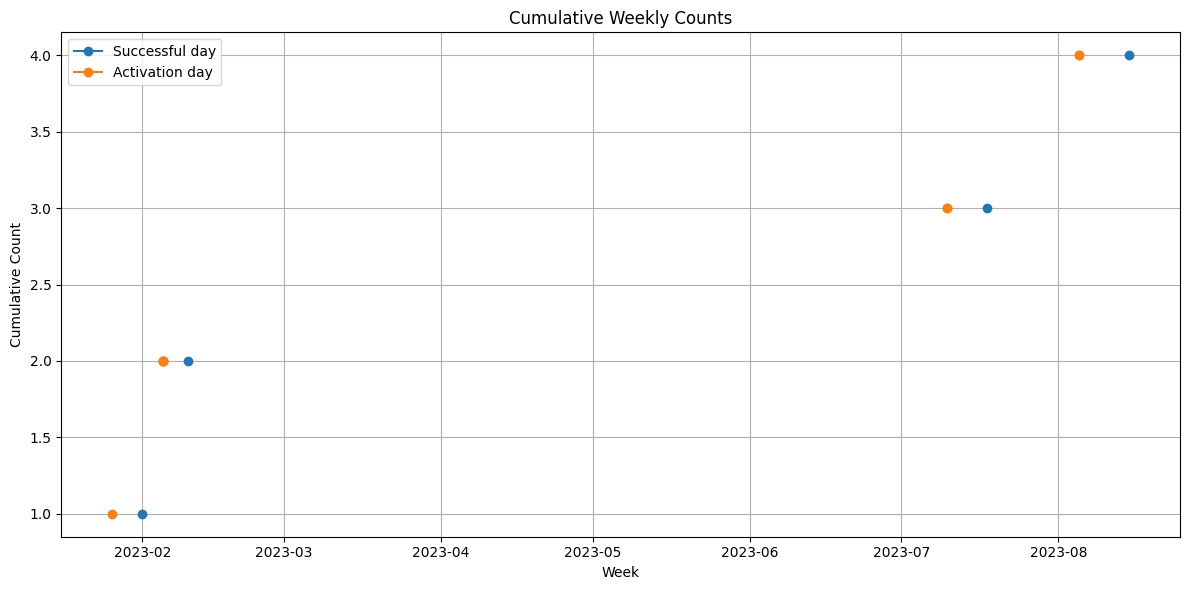

In [628]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(conv['date'], conv['successful_count'] , linestyle='-', marker='o', label='Successful day')
plt.plot(conv['date'], conv['activation_count'] , linestyle='-', marker='o', label='Activation day')
plt.title("Cumulative Weekly Counts")
plt.xlabel("Week")
plt.ylabel("Cumulative Count")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## Task 2

Month over month, What percentage of the recently closed companies were successful?. A recently closed company is a company closed in the previous 2 months, so for example, if you take as a reference October 2023, recently closed companies for that month, are companies that were closed on the months September and October.

A company is successful in a given month if in that month that company had more that 1500 successful conversations.

So for example if we have two companies with the following data

Company A:

- Sept 27th, 1000 successful conversations
- Sept 28th, 1000 successful conversations
- Oct 4th, 500 successful conversations

Company B:

- Sept 29th 1000 successful conversations
- Oct 1st 1000 successful conversations

Company A was successful on September, but it wasn’t on October. And company B, was not successful neither on September nor October, even though it has a window of less than 30 days with more than 1500 successful conversations.

So for this chart. In month October 2023 you would need to count how many companies were closed in months September and October, and from that set of companies calculate the percentage that deployed at least 1500 successful conversations in October.

So for example, if we want to calculate the percentage of October and have the following data

Company A, Close date: Oct 6th, Successful conversations in October: 4000

Company B, Close date: Sept 11h, Successful conversations in October: 1000

Company C, Close date: Aug 15th, Successful conversations in October: 5000

The percentage on October would be 50%. As from all recently closed customers taking October as a reference. In October all of them just 1 was successful

In [632]:
## Query template for extracting total successful conversations group by month and company name from previous to current target months

query_get_conversations = """
select
    TO_CHAR(cv.date, 'YYYY-MM') as date,
    c.name,
    sum(cv.total) successful_conversations
from conversations as cv
left join company_identifiers as ci
    on cv.account_id = ci.account_identifier
left join company as c
    on c.id = ci.company_id
where c.close_date between '{previous_month}' and '{current_month}' and cv.successful is true
group by 1, 2
;
"""

## Function to calculate last day from current month and first day from previous month
def get_date_range(given_date):
    # First day of the current month
    first_day_current_month = given_date.replace(day=1)
    # Last day of the previous month
    last_day_previous_month = first_day_current_month - timedelta(days=1)
    # First day of the previous month
    first_day_previous_month = last_day_previous_month.replace(day=1)
    last_day_current_month = (first_day_current_month.replace(month=first_day_current_month.month % 12 + 1, day=1) - timedelta(days=1)) if first_day_current_month.month != 12 else given_date.replace(year=given_date.year+1, month=1, day=1) - timedelta(days=1)
    return first_day_previous_month, last_day_current_month


In [633]:
first_days_of_2023 = [date(2023, month, 1) for month in range(1, 9)]
percentage_successful_companies = []

## Iter through all 2023 months
for month in first_days_of_2023:
    start, end = get_date_range(month)
    conversations = db_connection.make_query(query=query_get_conversations.format(previous_month=start, current_month=end)) ## Successful conversations for target month
    total_companies = len(conversations.name.unique()) ## Total number of companies' conversations for the target month
    mask = (conversations['date'] == month.strftime("%Y-%m")) & (conversations['successful_conversations'] >= 1500) ## Filtering company with more than 1500 conversations for the target month
    successful_company = len(conversations[mask].name.unique())
    percentage_per_month = (successful_company/total_companies)*100 ## Percentage of successful companies for each month 2023
    percentage_successful_companies.append(percentage_per_month)

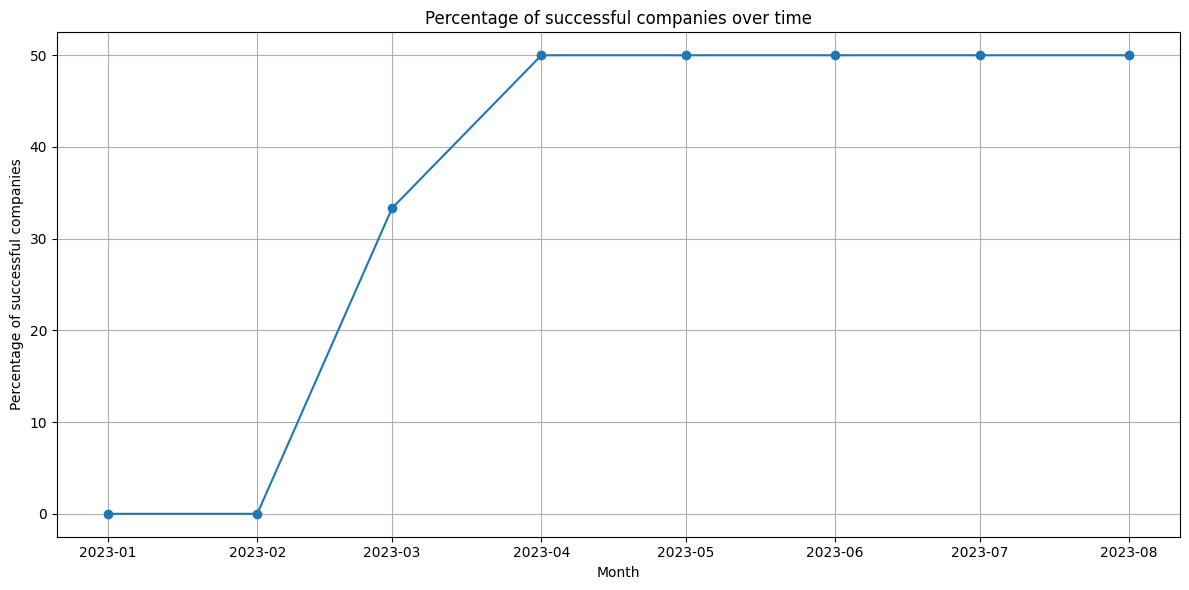

In [634]:
# Plotting
first_days_of_2023
percentage_successful_companies
plt.figure(figsize=(12, 6))
plt.plot(first_days_of_2023, percentage_successful_companies, linestyle='-', marker='o')
plt.title("Percentage of successful companies over time")
plt.xlabel("Month")
plt.ylabel("Percentage of successful companies")
plt.grid(True)
plt.tight_layout()
plt.show()

There is to notice that results in May 2023 are not the expected. However, results for others months are as expected

## Task 3

Create a cohorts chart of revenue in USD collected, each cohort (rows) groups the companies closed in the given month, and each column represents the number of months after close date. Graph should be exactly as below. As an example, at row ‘2023-02’ on the second column, it shows how much money was collected on March 2023 from all the companies that were closed on February.

Overlook the exact day the invoice was sent, and the or the exact day when the company signed the contract, you must take into account just the month. For example if a company was closed by a salesperson on 2023-05-23 and the first invoice has sent on 2023-06-02, that invoice would contribute to the cell located at row ‘2023-05’ and second column, despite the invoice being sent just a few days after the closing date. As another example if a company was closed at 2023-02-01 and the first invoice was sent on 2023-02-16, that invoice will contribute to the total amount of the cell located at row ‘2023-02’ and first column

In [637]:
## Getting company identifiers info

query_get_company_identifiers = """
select
    *
from company_identifiers
;
"""

company_identifier = db_connection.make_query(query=query_get_company_identifiers)
print(f'Number of columns: {company_identifier.shape[1]} - Number of rows: {company_identifier.shape[0]}')
print(f'Columns: {list(company_identifier.columns)}')
company_identifier

Number of columns: 3 - Number of rows: 21
Columns: ['account_identifier', 'company_id', 'stripe_company_ids']


,account_identifier,company_id,stripe_company_ids
0,1,1,"ak_1, ak_2"
1,2,1,"ak_1, ak_2"
2,3,2,ak_3
3,4,3,ak_4
4,5,3,ak_4
5,6,4,
6,7,5,ak_5
7,8,6,ak_7
8,9,7,ak_8
9,10,7,ak_8


In [638]:
## Parsing stripe companies id

df = company_identifier.copy()
df = df.assign(stripe_company_ids=df['stripe_company_ids'].str.split(', ')).explode('stripe_company_ids').drop_duplicates()
df

,account_identifier,company_id,stripe_company_ids
0,1,1,ak_1
0,1,1,ak_2
1,2,1,ak_1
1,2,1,ak_2
2,3,2,ak_3
3,4,3,ak_4
4,5,3,ak_4
5,6,4,
6,7,5,ak_5
7,8,6,ak_7


In [639]:
## Companies information

query_get_company = """
select
    *
from company
;
"""

company = db_connection.make_query(query=query_get_company)
print(f'Number of columns: {company.shape[1]} - Number of rows: {company.shape[0]}')
print(f'Columns: {list(company.columns)}')
company

Number of columns: 4 - Number of rows: 14
Columns: ['id', 'name', 'associated_partner', 'close_date']


,id,name,associated_partner,close_date
0,1,Test Company,Test Partner,2023-01-02
1,2,Quantum Bright Industries,None,2023-02-04
2,3,Quantum Bright Industries,Partner SSL,2023-03-01
3,5,Innovative Bright Systems,,2023-02-23
4,6,Evolve Smart Systems,,2023-04-04
5,7,Tech United Enterprises,,2023-04-04
6,8,Evolve Creative Innovations,,2023-01-24
7,9,Evolve United Systems,,2023-01-11
8,10,Delta Reliable Innovations,,2023-02-01
9,11,Solutions Trusted Partners,,2023-04-11


In [640]:
## Merging companies identifier with companies

result = df.merge(company[['id', 'close_date']], left_on='company_id', right_on='id', how='left')
result

,account_identifier,company_id,stripe_company_ids,id,close_date
0,1,1,ak_1,1.0,2023-01-02
1,1,1,ak_2,1.0,2023-01-02
2,2,1,ak_1,1.0,2023-01-02
3,2,1,ak_2,1.0,2023-01-02
4,3,2,ak_3,2.0,2023-02-04
5,4,3,ak_4,3.0,2023-03-01
6,5,3,ak_4,3.0,2023-03-01
7,6,4,,NaN,NaT
8,7,5,ak_5,5.0,2023-02-23
9,8,6,ak_7,6.0,2023-04-04


In [641]:
## Getting all invoices

query_get_invoices = """
SELECT
    *
from
    stripe_invoice
;
"""

invoice = db_connection.make_query(query=query_get_invoices)
print(f'Number of columns: {invoice.shape[1]} - Number of rows: {invoice.shape[0]}')
print(f'Columns: {list(invoice.columns)}')
invoice

Number of columns: 5 - Number of rows: 67
Columns: ['sent_date', 'invoice_id', 'company_id', 'amount', 'currency']


,sent_date,invoice_id,company_id,amount,currency
0,2023-01-24,H7C6C99YEO,ak_1,201,USD
1,2023-02-28,SZGDP7DSMW,ak_1,428,USD
2,2023-03-16,KB1Z5M9VCL,ak_1,460,USD
3,2023-04-30,3MGEN8IWVX,ak_1,86,USD
4,2023-05-07,64DSU7DJ1P,ak_1,401,USD
...,...,...,...,...,...
62,2023-08-31,9IZH99IA0G,ak_15,329,USD
63,2023-07-29,38TR4QBVYQ,ak_16,276,USD
64,2023-08-30,3PAHA5ZO0C,ak_16,119,USD
65,2023-08-02,H60GCVRKLV,ak_17,293,USD


In [642]:
## Merging invoices with stripe companies ids. This is necessary to get close date from company

invoice = invoice.merge(result[['stripe_company_ids', 'close_date']], left_on='company_id', right_on='stripe_company_ids', how='left').drop_duplicates()
invoice

,sent_date,invoice_id,company_id,amount,currency,stripe_company_ids,close_date
0,2023-01-24,H7C6C99YEO,ak_1,201,USD,ak_1,2023-01-02
2,2023-02-28,SZGDP7DSMW,ak_1,428,USD,ak_1,2023-01-02
4,2023-03-16,KB1Z5M9VCL,ak_1,460,USD,ak_1,2023-01-02
6,2023-04-30,3MGEN8IWVX,ak_1,86,USD,ak_1,2023-01-02
8,2023-05-07,64DSU7DJ1P,ak_1,401,USD,ak_1,2023-01-02
...,...,...,...,...,...,...,...
95,2023-08-31,9IZH99IA0G,ak_15,329,USD,ak_15,2023-06-11
96,2023-07-29,38TR4QBVYQ,ak_16,276,USD,ak_16,2023-07-11
98,2023-08-30,3PAHA5ZO0C,ak_16,119,USD,ak_16,2023-07-11
100,2023-08-02,H60GCVRKLV,ak_17,293,USD,ak_17,2023-08-07


In [643]:

# Assign Cohort for each cohort month
invoice['cohort'] = invoice['close_date'].dt.to_period('M')

# Time Since close date
invoice['months_since_close'] = (invoice['sent_date'].dt.to_period('M') - invoice['cohort']).apply(attrgetter('n'))

# cohort data
invo = invoice[invoice['months_since_close'] >= 0]
cohort_data = invo.groupby(['cohort', 'months_since_close']).amount.sum().unstack(1, fill_value=0)
cohort_data


months_since_close,0,1,2,3,4,5,6,7
cohort,,,,,,,,
2023-01,292,644,621,317,735,653,384,536
2023-02,754,317,307,187,228,57,95,0
2023-03,51,693,173,99,356,378,0,0
2023-04,206,278,79,52,85,0,0,0
2023-05,259,377,56,85,0,0,0,0
2023-06,404,160,329,0,0,0,0,0
2023-07,276,119,0,0,0,0,0,0
2023-08,1282,0,0,0,0,0,0,0


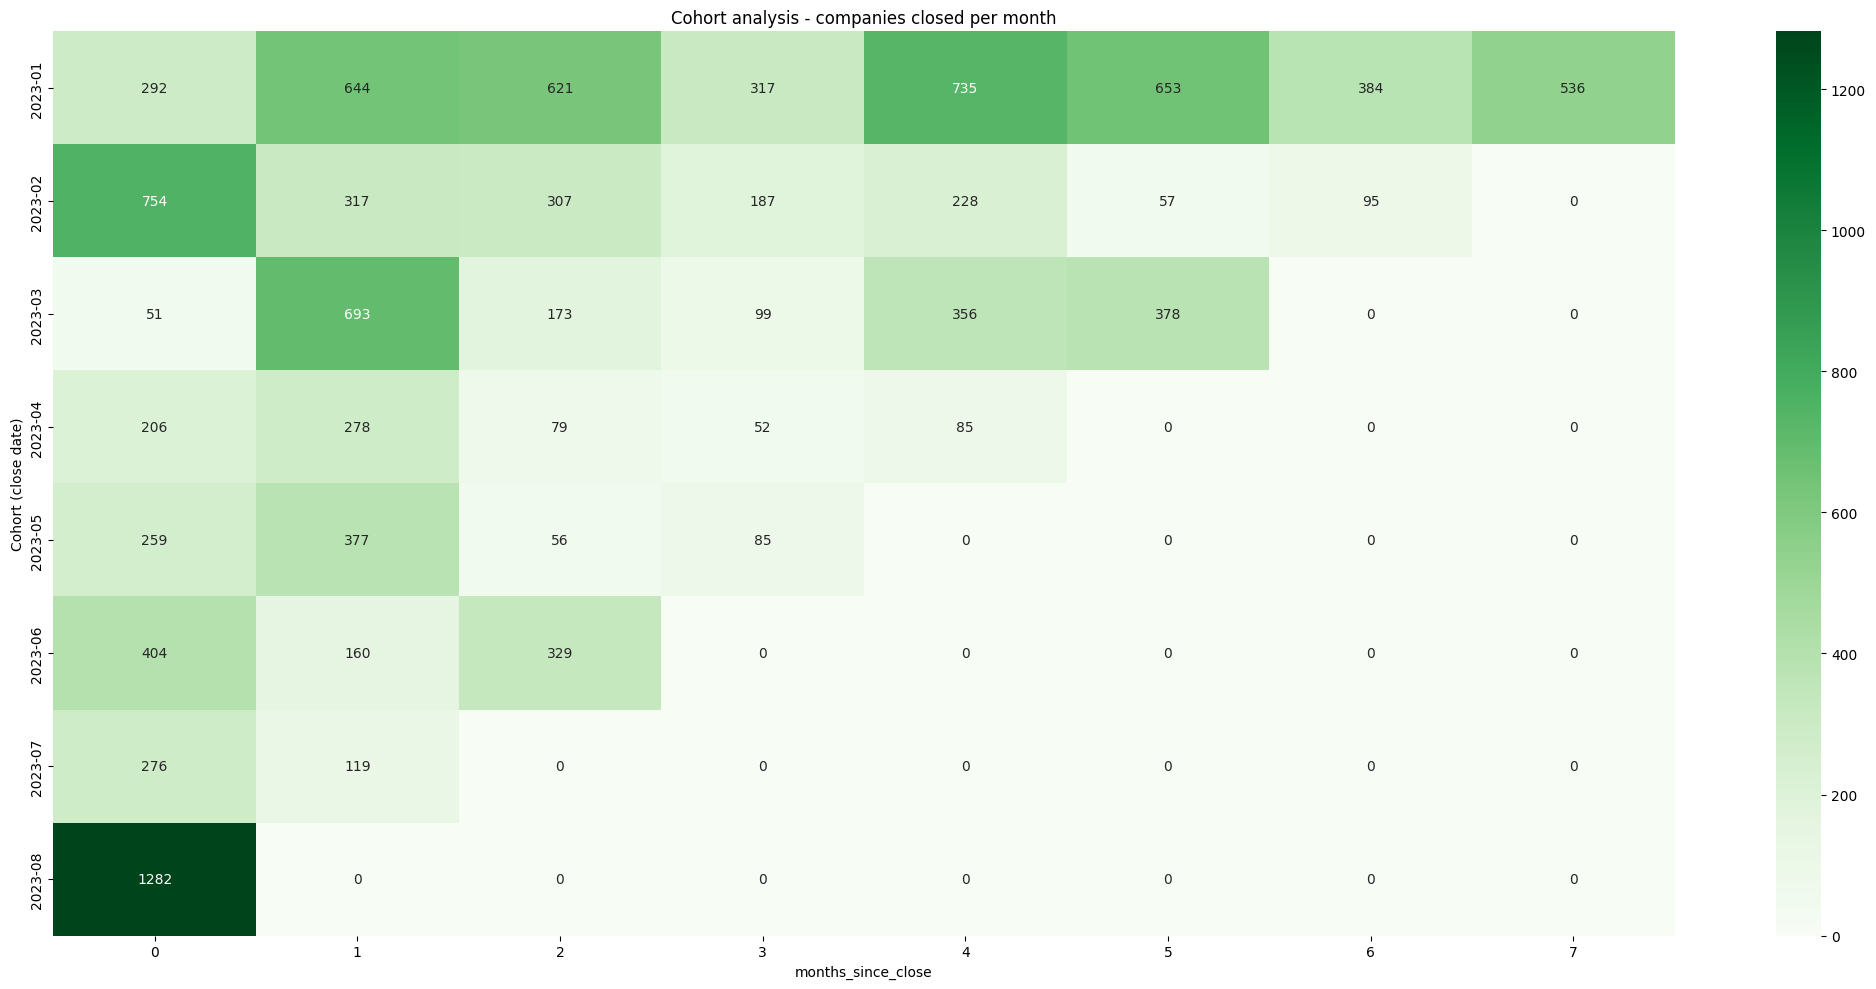

In [644]:
#creation of heatmap and visualization
plt.figure(figsize=(21,10))
sns.heatmap(cohort_data,annot=True,cmap='Greens', fmt=".4g")

plt.title("Cohort analysis - companies closed per month")
plt.ylabel("Cohort (close date)")
plt.tight_layout()
plt.show()

As seem in Task 2 results for 2023-05 seems to be shifted. All results for any other month are right.